In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import LATENT_FEATURES_DIR, RESULTS_DIR, SUBJECTS, FMRI_BETAS_SURFACE_DIR, STIM_INFO_PATH, COCO_IMAGES_DIR
from analyses.decoding.ridge_regression_decoding import NUM_CV_SPLITS, RIDGE_DECODER_OUT_DIR, pairwise_accuracy
from data import MODALITY_AGNOSTIC, MODALITY_SPECIFIC_IMAGES, MODALITY_SPECIFIC_CAPTIONS
from eval import ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST, get_distance_matrix, dist_mat_to_pairwise_acc
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN, ACC_CROSS_MEAN, PALETTE_BLACK_ONLY, METRICS_ERROR_ANALYSIS, get_data_default_feats, METRICS_BASE

/home/mitja/anaconda3/envs/multimodal_decoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODELS = ["random-imagebind", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower", "vilt", "clip", "flava", "blip2", "imagebind"]
for model in MODELS:
    print(model, end=" ")

random-imagebind vit-b-16 vit-l-16 resnet-18 resnet-50 resnet-152 dino-base dino-large dino-giant bert-base-uncased bert-large-uncased llama2-7b llama2-13b mistral-7b mixtral-8x7b gpt2-small gpt2-medium gpt2-large gpt2-xl visualbert bridgetower vilt clip flava blip2 imagebind 

In [3]:
all_data = load_results_data(MODELS, recompute_acc_scores=False)
# all_data = load_results_data(MODELS, recompute_acc_scores=True, standardize_predictions=True)

all_data = all_data[all_data["mask"] == "whole_brain"]
all_data = all_data[all_data.surface == False]

all_data
# for model in MODELS:
#     print(model, end=" ")
# all_data = all_data[all_data.subject.isin(['sub-01', 'sub-02', 'sub-03', 'sub-04'])]


100%|██████████| 84/84 [00:00<00:00, 1280.45it/s]


,model,subject,features,test_features,vision_features,lang_features,training_mode,mask,num_voxels,metric,value,surface,model_feat
0,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,agnostic,whole_brain,162649,pairwise_acc_captions,0.759834,False,blip2_avg
1,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,agnostic,whole_brain,162649,pairwise_acc_images,0.915942,False,blip2_avg
2,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,agnostic,whole_brain,162649,pairwise_acc_cross_images_to_captions,0.915942,False,blip2_avg
3,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,agnostic,whole_brain,162649,pairwise_acc_cross_captions_to_images,0.759834,False,blip2_avg
4,blip2,sub-01,avg,avg,vision_features_mean,lang_features_mean,agnostic,whole_brain,162649,pairwise_acc_imagery,0.833333,False,blip2_avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,imagebind,sub-07,vision,vision,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_cross_images_to_captions,0.934783,False,imagebind_vision
584,imagebind,sub-07,vision,vision,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_cross_captions_to_images,0.731884,False,imagebind_vision
585,imagebind,sub-07,vision,vision,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_imagery,0.833333,False,imagebind_vision
586,imagebind,sub-07,vision,vision,vision_features_cls,lang_features_cls,images,whole_brain,214739,pairwise_acc_imagery_whole_test_set,0.659624,False,imagebind_vision


In [4]:
FEATS_MULTIMODAL = ["fused_mean", "fused_cls", "avg", "matched"]

DEFAULT_FEAT_OPTIONS = ["vision", "lang"] + FEATS_MULTIMODAL

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODELS:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODELS:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

multimodal_models = all_data[all_data.features.isin(FEATS_MULTIMODAL)].model.unique().tolist()
multimodal_models
# for model in MODELS:
#     print(model, end=" ")

all_data.model.unique()

array(['blip2', 'clip', 'dino-base', 'dino-giant', 'dino-large', 'flava',
       'gpt2-large', 'gpt2-medium', 'gpt2-xl', 'imagebind', 'vilt'],
      dtype=object)

## Feature comparison for multimodal models

In [5]:
# data_default_vision_feats = all_data.copy()
# for model in all_data.model.unique():
#     default_vision_feats = get_default_vision_features(model)
#     data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
# feat_legend = {"vision": "vision feature space", "lang": "language feature space", "concat": "multimodal feature space: concat", "avg": "multimodal feature space: avg", "matched": "matched feature space", "fused_cls": "fused cls", "fused_mean": "fused mean"}
# feat_order = ["vision", "lang", "fused_cls", "fused_mean", "matched", "avg", "concat"]
# feat_order_long = [feat_legend[feat] for feat in feat_order]

# data_to_plot = data_default_vision_feats.copy()

# model_feats_exluded = ["bridgetower_multi"]
# data_to_plot = data_to_plot[~data_to_plot.model_feat.isin(model_feats_exluded)].copy()

# data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

# data_to_plot["features"] = data_to_plot.features.replace(feat_legend)

# model_feat_order = calc_model_feat_order(data_to_plot, feat_options=feat_order)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=feat_order_long, ylim=(0.5, 1),
#                              legend_bbox=(0.06,1.01), height=4.5, legend_title="Modality-agnostic decoders projecting into", verify_num_datapoints=False, plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [6]:
data_mod_agnostic_train = all_data[(all_data.metric == ACC_MEAN) & (all_data.training_mode == MODALITY_AGNOSTIC)]

# data_mod_agnostic_train = all_data[(all_data.metric == ACC_CAPTIONS) & (all_data.training_mode == "modality-agnostic") & (all_data.subject == 'sub-01')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    grouped = data_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc=('value', 'mean')).reset_index()

    # grouped = grouped[grouped.model.isin(multimodal_models)]
    display(grouped)

# print(grouped.to_markdown())

# grouped = grouped.replace("n_a", "")
# grouped = grouped[grouped.model.isin(multimodal_models)]
# del grouped["count"]
# print(grouped.to_latex(index=False, escape=True, float_format="%.3f"))



,model,features,vision_features,lang_features,count,pairwise_acc
0,blip2,avg,vision_features_mean,lang_features_mean,6,0.852640
1,clip,avg,vision_features_cls,lang_features_cls,6,0.838233
2,dino-base,vision,vision_features_mean,n_a,6,0.822101
3,dino-giant,vision,vision_features_mean,n_a,6,0.822533
4,dino-large,vision,vision_features_mean,n_a,6,0.819306
5,flava,avg,vision_features_mean,lang_features_mean,6,0.850311
6,gpt2-large,lang,n_a,lang_features_mean,6,0.850897
7,gpt2-medium,lang,n_a,lang_features_mean,6,0.846014
8,gpt2-xl,lang,n_a,lang_features_mean,6,0.848378
9,imagebind,avg,vision_features_cls,lang_features_cls,6,0.851311


## Feature comparison for GloW models

In [7]:
# all_data_glow_comparisons = load_results_data(MODELS_GLOW_COMPARISON)

# data_glow_mod_agnostic_train = all_data_glow_comparisons[(all_data_glow_comparisons.metric == ACC_MODALITY_AGNOSTIC) & (all_data_glow_comparisons.training_mode == "modality-agnostic")]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     grouped_glow = data_glow_mod_agnostic_train.groupby(["model", "features", "vision_features", "lang_features"]).agg(count=('value', 'size'), pairwise_acc_modality_agnostic=('value', 'mean')).reset_index()
#     display(grouped_glow)


## Modality-agnostic decoding vs. modality-specific decoding

In [8]:
data_default_feats = get_data_default_feats(all_data)

In [9]:
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]

vision_models = [m for m in all_data[all_data.features == "vision"].model.unique() if len(all_data[all_data.model == m].features.unique()) == 1]
# for m in multimodal_models:
#     print(m, end=" ")


### Model features comparison

In [10]:
model_order = ['random-imagebind']
for features in DEFAULT_FEAT_OPTIONS:
    print(features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == MODALITY_AGNOSTIC]
    
    dp = dp[dp.metric == ACC_CAPTIONS]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend(scores.index.values)
    
model_order

vision
model
dino-giant    0.723154
dino-large    0.725397
dino-base     0.732367
Name: value, dtype: float64
lang
model
gpt2-medium    0.803761
gpt2-xl        0.806556
gpt2-large     0.810732
Name: value, dtype: float64
fused_mean
model
vilt    0.758006
Name: value, dtype: float64
fused_cls
avg
model
clip         0.759731
blip2        0.773326
imagebind    0.788958
flava        0.797688
Name: value, dtype: float64
matched


['random-imagebind',
 'dino-giant',
 'dino-large',
 'dino-base',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'vilt',
 'clip',
 'blip2',
 'imagebind',
 'flava']

In [11]:
model_order = ['random-imagebind']
for features in DEFAULT_FEAT_OPTIONS:
    print(features)
    dp = data_default_feats.copy()
    dp = dp[dp.features == features]
    dp = dp[dp.training_mode == MODALITY_AGNOSTIC]
    
    dp = dp[dp.metric == ACC_MEAN]
    for model in dp.model.unique():
        if len(dp[dp.model == model]) != len(SUBJECTS):
            print(f"unexpected number of datapoints for {model}: {len(dp[dp.model == model])}")
    scores = dp.groupby("model").value.mean().sort_values()
    if len(scores) > 0:
        print(scores)
        model_order.extend(scores.index.values)
    
model_order

vision
model
dino-large    0.819306
dino-base     0.822101
dino-giant    0.822533
Name: value, dtype: float64
lang
model
gpt2-medium    0.846014
gpt2-xl        0.848378
gpt2-large     0.850897
Name: value, dtype: float64
fused_mean
model
vilt    0.8407
Name: value, dtype: float64
fused_cls
avg
model
clip         0.838233
flava        0.850311
imagebind    0.851311
blip2        0.852640
Name: value, dtype: float64
matched


['random-imagebind',
 'dino-large',
 'dino-base',
 'dino-giant',
 'gpt2-medium',
 'gpt2-xl',
 'gpt2-large',
 'vilt',
 'clip',
 'flava',
 'imagebind',
 'blip2']

['dino-base_vision', 'dino-large_vision', 'dino-giant_vision', 'gpt2-medium_lang', 'gpt2-large_lang', 'gpt2-xl_lang', 'vilt_fused_mean', 'clip_avg', 'flava_avg', 'blip2_avg', 'imagebind_avg']


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(


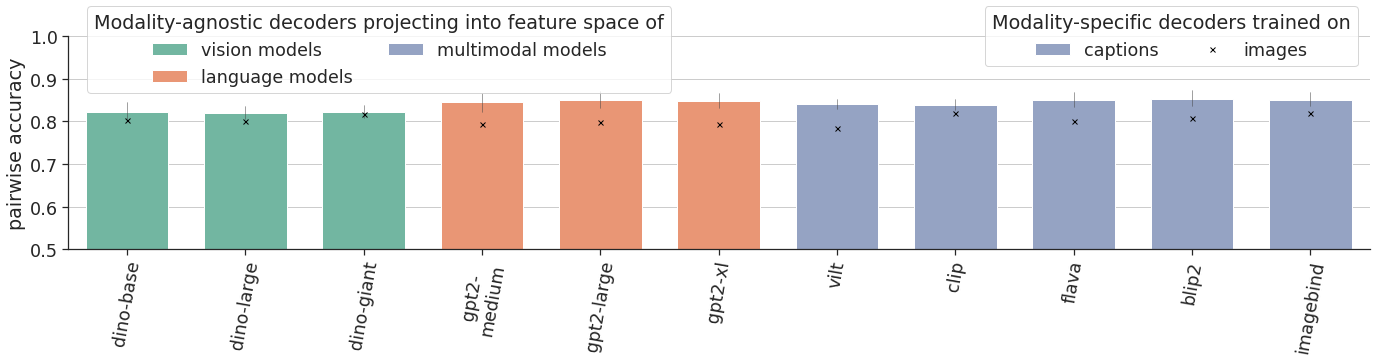

In [12]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)
print(model_feat_order)
metrics_order = [ACC_MEAN]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,1.02), legend_2_bbox=(0.99,1.02), height=5, aspect=3.2, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


/home/mitja/multimodal_decoding/notebooks/notebook_utils.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IndexError: list index out of range

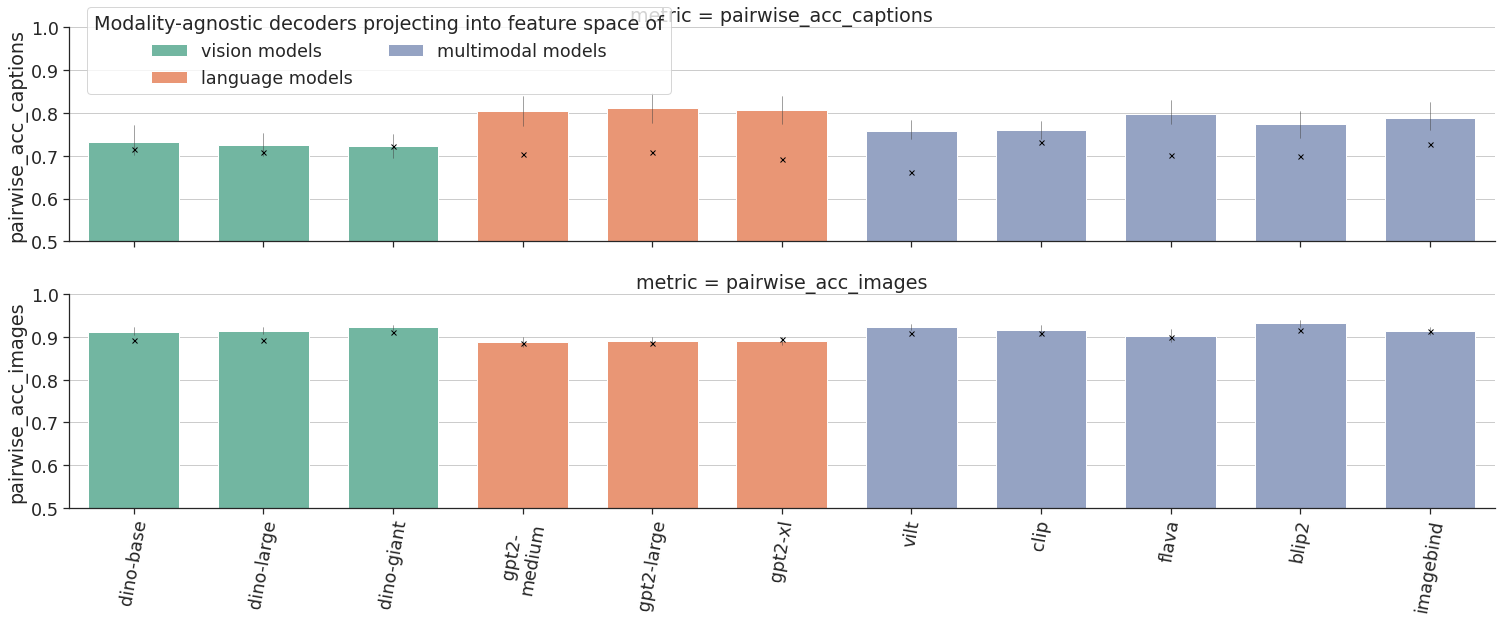

In [14]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_CAPTIONS, ACC_IMAGES]
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_split_by_modality.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [ ]:
sns.set(font_scale=1.6)
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = [ACC_IMAGERY, ACC_IMAGERY_WHOLE_TEST] #ACC_MEAN
figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
                             legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_imagery.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


In [ ]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CAPTIONS, ACC_IMAGES, ACC_MODALITY_AGNOSTIC]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
#                              legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False,
#                              plot_modality_specific=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_only_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## Per-subject results

In [ ]:
FEAT_ORDER = ["vision", "lang", "matched"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, order=model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    # assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6
    for mode in ["modality-agnostic", "captions", "images"]:
        data_mode = data[data.training_mode == mode]
        for x_variable_value in order:
            length = len(data_mode[(data_mode["model_feat"] == x_variable_value) & (data_mode.metric == metrics[0])])
            expected_num_datapoints = len(SUBJECTS)
            if hue_variable != "features":
                expected_num_datapoints *= len(data[hue_variable].unique())
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {x_variable_value} {mode}"
                print(f"Warning: {message}")

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            palette = PALETTE_BLACK_ONLY
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=palette, axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


In [ ]:
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_default_feats.copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=[ACC_CAPTIONS, ACC_IMAGES], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

# Cross-modal decoding

In [ ]:
# sns.set(font_scale=1.6)
# TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision models", "language models", "multimodal models"]

# data_to_plot = data_default_feats.copy()

# data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models"})
# data_to_plot["features"] = data_to_plot.features.replace({f: "multimodal models" for f in FEATS_MULTIMODAL})

# model_feat_order = calc_model_feat_order(data_to_plot)

# metrics_order = [ACC_CROSS_IMAGES_TO_CAPTIONS, ACC_CROSS_CAPTIONS_TO_IMAGES, ACC_CROSS_MEAN]
# figure, lgd = create_result_graph(data_to_plot, order=model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,1.05), legend_2_bbox=(0.99,1.05), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"cross_modal_decoding_features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

# 

# Error analysis

In [ ]:
models = ['imagebind']

data = load_results_data(models, metrics=METRICS_ERROR_ANALYSIS)

# metric = ACC_IMAGES

all_data = data[data.model.isin(MODELS)]

all_data = all_data[all_data["mask"] == "whole_brain"]

all_data = all_data[all_data.surface == False]

data_default_feats_err_analysis = get_data_default_feats(all_data)

In [ ]:
def all_pairwise_accuracy_scores(latents, predictions, stim_types=None, metric="cosine", normalize=True):
    results = dict()
    results['comp_mats'] = dict()
    
    for modality, acc_metric_name in zip([CAPTION, IMAGE], [ACC_CAPTIONS, ACC_IMAGES]):
        preds_mod = predictions[stim_types == modality].copy()
        latents_mod = latents[stim_types == modality]
        if normalize:
            pred_mod_normalize = Standardize(preds_mod.mean(axis=0), preds_mod.std(axis=0))
            preds_mod = pred_mod_normalize(preds_mod)

        dist_mat = get_distance_matrix(preds_mod, latents_mod, metric)
        diag = dist_mat.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat

        score = dist_mat_to_pairwise_acc(dist_mat)

        results[acc_metric_name] = score
        results['comp_mats'][acc_metric_name] = (~comp_mat).astype(int)

    if normalize:
        pred_normalize = Standardize(predictions.mean(axis=0), predictions.std(axis=0))
        predictions = pred_normalize(predictions)

    dist_mat = get_distance_matrix(predictions, latents, metric)

    mod_agnostic_accs = []
    for modality in [CAPTION, IMAGE]:
        dist_mat_within_mod = dist_mat[stim_types == modality][:, stim_types == modality]
        dist_mat_cross_modal = dist_mat[stim_types == modality][:, stim_types != modality]
        dist_mat_min = np.min((dist_mat_within_mod, dist_mat_cross_modal), axis=0)
        diag = dist_mat_min.diagonal().reshape(-1, 1)
        comp_mat = diag < dist_mat_min
        score = dist_mat_to_pairwise_acc(dist_mat_min)
        # scores = np.mean(comp_mat, axis=0)
        mod_agnostic_accs.append(score)
        results[f"pairwise_acc_mod_agnostic_{modality}s"] = score
        results['comp_mats'][f"pairwise_acc_mod_agnostic_{modality}s"] = (~comp_mat).astype(int)

    results[ACC_MODALITY_AGNOSTIC] = np.mean(mod_agnostic_accs)

    return results

all_subj_mats = []
for subject in SUBJECTS:
    df = data_default_feats_err_analysis.copy()
    df_subj = df[(df.training_mode == 'modality-agnostic') & (df.subject == subject)]
    predictions = df_subj[df_subj.metric == "predictions"].value.item()
    latents = df_subj[df_subj.metric == "latents"].value.item()
    stimulus_ids = df_subj[df_subj.metric == "stimulus_ids"].value.item()
    stimulus_types = df_subj[df_subj.metric == "stimulus_types"].value.item()
    
    results = all_pairwise_accuracy_scores(latents, predictions, stimulus_types)
    print(results[ACC_MODALITY_AGNOSTIC])
    mat = results['comp_mats'][metric]
    all_subj_mats.append(mat)

mat = np.sum(all_subj_mats, axis=0)
mat = mat - np.diag(np.diag(mat))

df_err = pd.DataFrame(mat, index=stimulus_ids[:70], columns=stimulus_ids[:70])

In [ ]:
# df_err = df_err.map(lambda x: 0 if x < 3 else x)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df_err)

In [ ]:
stimuli_info = np.load(STIM_INFO_PATH, allow_pickle=True)
img_paths = {id: os.path.join(COCO_IMAGES_DIR, path) for id, path, caption in stimuli_info}
captions_dict = {id: caption for id, path, caption in stimuli_info}

from PIL import Image

def display_stimuli(coco_ids):
    imgs = [Image.open(img_paths[img_id]).convert('RGB') for img_id in coco_ids]
    min_height = np.min([np.array(im).shape[0] for im in imgs])
    stacked = np.hstack([np.array(im)[:min_height,:,:] for im in imgs])
    img = Image.fromarray(stacked)
    # print(min_height)
    captions = [captions_dict[coco_id] for coco_id in coco_ids]
    for cap in captions:
        print(cap)
    display(img)
    
# display_imgs([183210, 79642])


In [ ]:
for id1, row in df_err.iterrows():
    confusions = []
    for id2, count in row.items():
        if count > 5:
            confusions.append(id2)
    if len(confusions) > 0:
        print(f'common confusions involving id {id1}:\n')
        confusions = [id1] + confusions
        display_stimuli(confusions)
        print('\n\n')
